In [1]:
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt

ak_arrayA = ak.from_parquet("extracted_dataA.parquet")
ak_arrayB = ak.from_parquet("extracted_dataB.parquet")
ak_arrayC = ak.from_parquet("extracted_dataC.parquet")
ak_arrayD = ak.from_parquet("extracted_dataD.parquet")

ak_array1 = ak.from_parquet("extracted_mcgg.parquet")
ak_array2 = ak.from_parquet("extracted_mcVBF.parquet")
ak_array3 = ak.from_parquet("extracted_mcW.parquet")
ak_array4 = ak.from_parquet("extracted_mcZ.parquet")

ak_arraybkg = ak.from_parquet("extracted_mcbkg.parquet")

# Convert to pandas DataFrame
dfA = pd.DataFrame({k: ak_arrayA[k].to_list() for k in ak_arrayA.fields})
dfB = pd.DataFrame({k: ak_arrayB[k].to_list() for k in ak_arrayB.fields})
dfC = pd.DataFrame({k: ak_arrayC[k].to_list() for k in ak_arrayC.fields})
dfD = pd.DataFrame({k: ak_arrayD[k].to_list() for k in ak_arrayD.fields})

df = pd.concat([dfA, dfB, dfC, dfD], axis=0, ignore_index=True)

df1 = pd.DataFrame({k: ak_array1[k].to_list() for k in ak_array1.fields})
df2 = pd.DataFrame({k: ak_array2[k].to_list() for k in ak_array2.fields})
df3 = pd.DataFrame({k: ak_array3[k].to_list() for k in ak_array3.fields})
df4 = pd.DataFrame({k: ak_array4[k].to_list() for k in ak_array4.fields})

df_sig = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)

df_bkg = pd.DataFrame({k: ak_arraybkg[k].to_list() for k in ak_arraybkg.fields})

In [2]:
print(np.shape(df), np.shape(df_sig), np.shape(df_bkg))
print(df_bkg.columns)

(832, 12) (385706, 12) (554279, 12)
Index(['lep_charge', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_E', 'lep_type',
       'lep_isTightID', 'lep_ptcone30', 'lep_etcone20', 'mcWeight',
       'runNumber', 'met_et'],
      dtype='object')


In [9]:
### sorting out the 4l events
def lep_channel(lep_type):
    lep_type = np.array(lep_type)
    n_e  = np.sum(lep_type == 11)
    n_mu = np.sum(lep_type == 13)

    return (n_e == 4) or (n_mu == 4) or (n_e == 2 and n_mu == 2)
    
mask = df['lep_type'].apply(lep_channel)
data1 = df[mask]

mask = df_sig['lep_type'].apply(lep_channel)
sig1 = df_sig[mask]

mask = df_bkg['lep_type'].apply(lep_channel)
bkg1 = df_bkg[mask]

print(np.shape(data1))

(606, 12)


In [124]:
### event selection
def cuts(event):
    pt = np.array(event['lep_pt'])/1000
    eta = np.abs(np.array(event['lep_eta']))
    phi = np.array(event['lep_phi'])
    t = np.array(event['lep_type'])

    ## forward tracks cut
    if not np.all((eta < 2.45)): 
        return False

    ## transverse momentum cut
    pass_e  = (t != 11) | (pt > 15)   # electrons
    pass_mu = (t != 13) | (pt > 13)   # muons
    if not np.all(pass_e & pass_mu):
        return False

    ## tight ID
    if not np.all(event['lep_isTightID']):
        return False

    ## isolation
    ptcone = np.array(event['lep_ptcone30'])/1000
    if not np.all(ptcone / pt < 0.15):
        return False

    ## leading/subleading/third momentum cut
    pt_sorted = np.sort(pt)[::-1]  # sort descending order

    if pt_sorted[0] <= 25:
        return False
    if pt_sorted[1] <= 20:
        return False
    if pt_sorted[2] <= 15:
        return False

    ## if it passes all cuts
    return True

data2 = data1[data1.apply(cuts, axis=1)]
sig2  = sig1[sig1.apply(cuts, axis=1)]
bkg2  = bkg1[bkg1.apply(cuts, axis=1)]

In [125]:
print(np.shape(data2))

(140, 12)


In [ ]:
def z_mass_cut(event):
    pt = np.array(event['lep_pt'])/1000
    eta = np.abs(np.array(event['lep_eta']))
    phi = np.array(event['lep_phi'])
    t = np.array(event['lep_type'])
    E = np.array(event['lep_E'])/1000
    charge = np.array(event['lep_charge'])
    
    def inv_mass(E,pt,eta,phi):
        px = pt * np.cos(phi)
        py = pt * np.sin(phi)
        pz = pt * np.sinh(eta)
        
        px_tot = np.sum(px)
        py_tot = np.sum(py)
        pz_tot = np.sum(pz)
        E_tot  = np.sum(E)

        m2 = E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2)
        return np.sqrt(np.maximum(m2,0))
        
    ## find all SFOS (same flavor opposite sign) pairs
    sfos_pairs = []
    for i in range(4):
        for j in range(i+1,4):
            if (t[i] == t[j]) and (charge[i] * charge[j] == -1):
                sfos_pairs.append((i,j))
    
    if len(sfos_pairs) < 2:
        return False

    ## sort leading pair = closest to mZ
    mZ = 90
    masses = [inv_mass(pt[[i,j]], eta[[i,j]], phi[[i,j]], E[[i,j]]) for i,j in sfos_pairs]
    idx_leading = np.argmin(np.abs(np.array(masses) - mZ))
    i,j = sfos_pairs[idx_leading]
    m12 = masses[idx_leading]
    
    # remaining pair = subleading
    rem_indices = list({0,1,2,3} - {i,j})
    m34 = inv_mass(pt[rem_indices], eta[rem_indices], phi[rem_indices], E[rem_indices])

    ## and now applying cuts
    if not (50 < m12 < 106):
        return False
    if not (12 < m34 < 115):
        return False
    
    return True

data3 = data2[data2.apply(z_mass_cut, axis=1)]
sig3  = sig2[sig2.apply(z_mass_cut, axis=1)]
bkg3  = bkg2[bkg2.apply(z_mass_cut, axis=1)]

In [ ]:
print(np.shape(data3))

In [ ]:
def compute_m4l(event):
    pt = np.array(event['lep_pt']) * 1e-3
    eta = np.array(event['lep_eta'])
    phi = np.array(event['lep_phi'])
    E = np.array(event['lep_E']) * 1e-3

    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)

    E_tot = np.sum(E)
    px_tot = np.sum(px)
    py_tot = np.sum(py)
    pz_tot = np.sum(pz)

    m2 = E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2)
    return np.sqrt(np.maximum(m2, 0.0))
data3 = data3.copy()
sig3  = sig3.copy()
bkg3  = bkg3.copy()

data3.loc[:, 'm4l'] = data3.apply(compute_m4l, axis=1)
sig3.loc[:, 'm4l']  = sig3.apply(compute_m4l, axis=1)
bkg3.loc[:, 'm4l']  = bkg3.apply(compute_m4l, axis=1)

In [ ]:
sb_data = (data3['m4l'] > 105) & (data3['m4l'] < 160) & ~((data3['m4l'] > 115) & (data3['m4l'] < 130))
sb_sig  = (sig3['m4l']  > 105) & (sig3['m4l']  < 160) & ~((sig3['m4l']  > 115) & (sig3['m4l']  < 130))
sb_bkg  = (bkg3['m4l']  > 105) & (bkg3['m4l']  < 160) & ~((bkg3['m4l']  > 115) & (bkg3['m4l']  < 130))

N_data_sb = sb_data.sum()
N_sig_sb  = sig3.loc[sb_sig, 'mcWeight'].sum()
N_bkg_sb  = bkg3.loc[sb_bkg, 'mcWeight'].sum()

scale = N_data_sb / N_bkg_sb
bkg3['w_norm'] = bkg3['mcWeight'] * scale
sig3['w_norm'] = sig3['mcWeight'] * scale

hw_data = (data3['m4l'] > 115) & (data3['m4l'] < 130)
hw_sig  = (sig3['m4l']  > 115) & (sig3['m4l']  < 130)
hw_bkg  = (bkg3['m4l']  > 115) & (bkg3['m4l']  < 130)

N_data = hw_data.sum()
N_sig  = sig3.loc[hw_sig, 'w_norm'].sum()
N_bkg  = bkg3.loc[hw_bkg, 'w_norm'].sum()

Z = (N_data - N_bkg) / np.sqrt(N_bkg)
print(N_data, N_sig, N_bkg)
print("Significance ~", Z, "sigma")

In [ ]:
#this is as far as i got

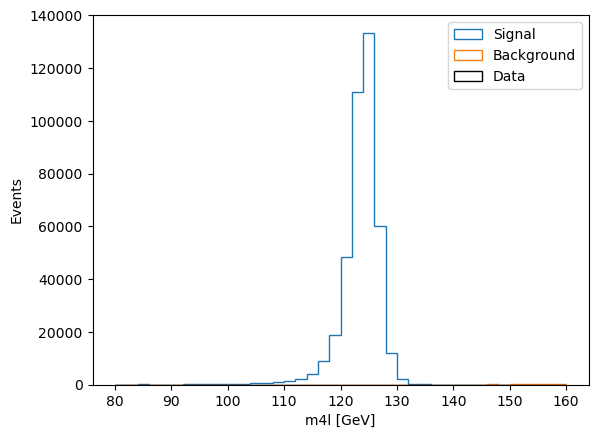

In [102]:
plt.hist(sig3['m4l'], bins=40, range=(80,160),
         weights=sig3['mcWeight'], histtype='step', label='Signal')

plt.hist(bkg3['m4l'], bins=40, range=(80,160),
         weights=bkg3['mcWeight'], histtype='step', label='Background')

plt.hist(data3['m4l'], bins=40, range=(80,160),
         histtype='step', label='Data', color='black')

plt.xlabel('m4l [GeV]')
plt.ylabel('Events')
plt.legend()
plt.show()


In [101]:
# Count events in Higgs window
m_low, m_high = 115, 130
N_data = ((data3['m4l'] > m_low) & (data3['m4l'] < m_high)).sum()
N_sig = sig3.loc[(sig3['m4l'] > 115) & (sig3['m4l'] < 130), 'mcWeight'].sum()
N_bkg = bkg3.loc[(bkg3['m4l'] > 115) & (bkg3['m4l'] < 130), 'mcWeight'].sum()

print(N_data, N_sig, N_bkg)
Z = (N_data - N_bkg)/np.sqrt(N_bkg)
print("Significance ~", Z, "sigma")

1 395565.9871313572 91.48175278655253
Significance ~ -9.460057289901753 sigma


In [29]:
import numpy as np

# Convert each event's pt list to a NumPy array (in GeV), then make a Python list of arrays
list_of_arrays = data1['lep_ptcone30'].apply(lambda x: np.array(x)).tolist()

# Concatenate all arrays into a single 1D array
all_pt = np.concatenate(list_of_arrays)

# Maximum lepton pt
max_pt = all_pt.max()
print(max_pt)

103539.25


(array([[2., 0., 2., ..., 0., 0., 0.],
        [0., 1., 2., ..., 0., 0., 0.],
        [3., 0., 0., ..., 0., 0., 0.],
        ...,
        [2., 1., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [2., 0., 0., ..., 0., 0., 0.]]),
 array([   7052.1484375,   61669.7925   ,  116287.4365625,  170905.080625 ,
         225522.7246875,  280140.36875  ,  334758.0128125,  389375.656875 ,
         443993.3009375,  498610.945    ,  553228.5890625,  607846.233125 ,
         662463.8771875,  717081.52125  ,  771699.1653125,  826316.809375 ,
         880934.4534375,  935552.0975   ,  990169.7415625, 1044787.385625 ,
        1099405.0296875, 1154022.67375  , 1208640.3178125, 1263257.961875 ,
        1317875.6059375, 1372493.25     ]),
 <a list of 256 BarContainer objects>)

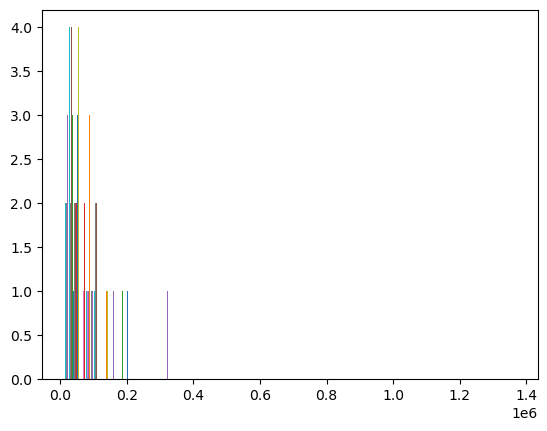

In [9]:
# print(df_selected['lep_E'][:10])
plt.hist(df_selected['lep_E'],bins=25)

In [14]:
print(np.max(df_selected['lep_eta']))

[2.460472583770752, 2.33640193939209, -0.7088855504989624, -0.1165785863995552]
